In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import warnings
warnings.simplefilter('ignore')

In [2]:
#download data
ibm = pdr.DataReader('IBM', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30))

In [3]:
ibm.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-08-01,191.500000,188.860001,190.500000,189.149994,5181100.0,143.561371
2014-08-04,189.949997,188.600006,189.350006,189.639999,2125900.0,143.933304
2014-08-05,189.199997,186.440002,188.750000,187.100006,3307900.0,142.005493
2014-08-06,186.880005,184.440002,185.360001,185.970001,3847000.0,141.982544
2014-08-07,186.679993,183.580002,186.639999,184.300003,2708600.0,140.707535


In [4]:
#export and save as csv files
ibm.to_csv('IBM_stock.csv', sep=',')

Text(0.5, 1.0, 'Original Data')

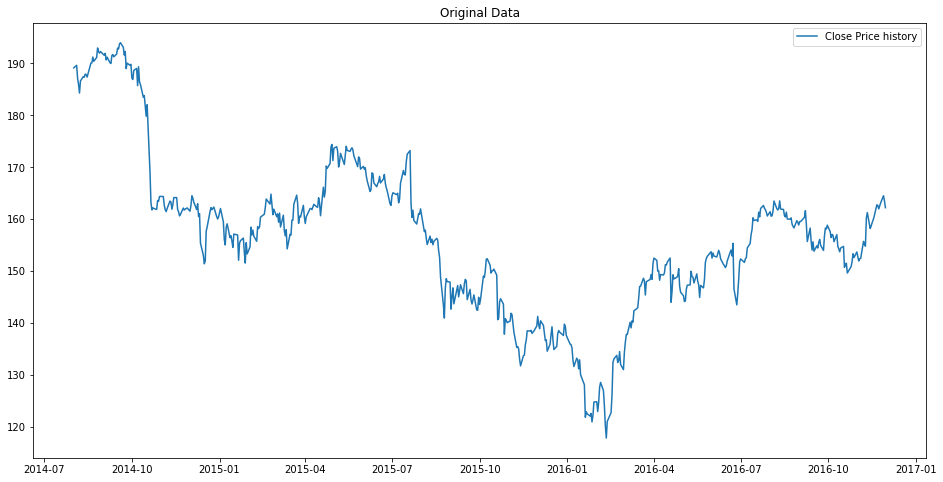

In [5]:
plt.figure(figsize=(16,8))
plt.plot(ibm['Close'], label='Close Price history')
plt.legend()
plt.title('Original Data')

<Figure size 432x288 with 0 Axes>

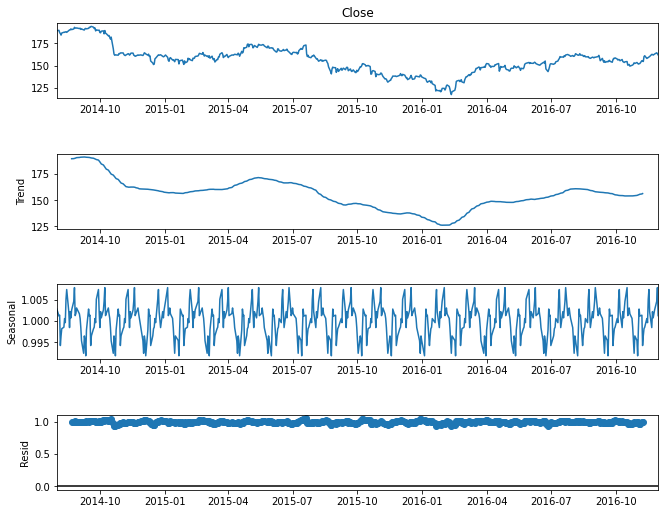

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ibm["Close"], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 8)

In [7]:
def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = ibm[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('Close')

Results of Dickey-Fuller Test for  Close 

Test Statistic                  -2.279273
p-value                          0.178740
#Lags Used                       0.000000
Number of Observations Used    588.000000
Critical Value (1%)             -3.441520
Critical Value (5%)             -2.866468
Critical Value (10%)            -2.569394
dtype: float64


ADF test: The test statistic is greater than the critical value, so we fail to reject the null hypothesis. So it is non-stationary series. Also P value is greater than 0.05 so, from that also we can say it in non-stationary.

In [8]:
def kpss_test(atr):
    timeseries = ibm[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('Close')

Results of KPSS Test for  Close
Test Statistic            1.268862
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


KPSS Test: The test statistic is greater than the critical value so we can reject the null hypothesis. So it is non-stationary series.

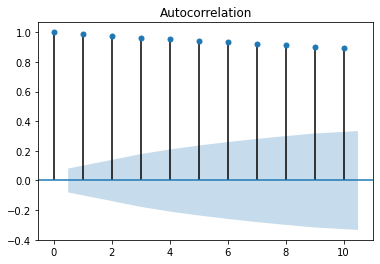

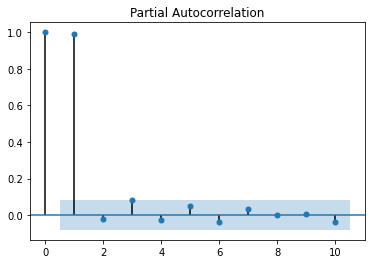

In [9]:
plot_acf(ibm['Close'].dropna(), lags=10)
plt.show()
plot_pacf(ibm['Close'].dropna(), lags=10)
plt.show()

From ACF plot also, we can see that at each lag autocorelation decreasing slowly. So data is non stationary and to make it stationary we can use differencing method. 

Here, I have used simple differencing and plotted the acf,pacf again to see status of stationarity.


In [10]:
ibm['Diff'] = ibm['Close'].diff(periods=1)

In [11]:
adf_test('Diff')

Results of Dickey-Fuller Test for  Diff 

Test Statistic                -1.843371e+01
p-value                        2.166547e-30
#Lags Used                     1.000000e+00
Number of Observations Used    5.860000e+02
Critical Value (1%)           -3.441558e+00
Critical Value (5%)           -2.866485e+00
Critical Value (10%)          -2.569403e+00
dtype: float64


In [12]:
kpss_test('Diff')

Results of KPSS Test for  Diff
Test Statistic            0.251866
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


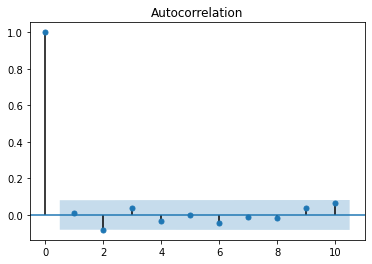

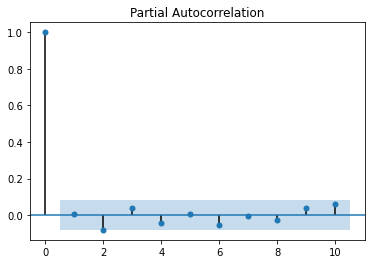

In [13]:
plot_acf(ibm['Diff'].dropna(), lags=10)
plt.show()
plot_pacf(ibm['Diff'].dropna(), lags=10)
plt.show()

## **ARIMA Model**

In [14]:
from statsmodels.tsa.arima_model import ARIMA

In [15]:
!pip3 install pmdarima

In [16]:
data = ibm['Close'].to_numpy()
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):]
date = (ibm.index)

In [17]:
import pmdarima as pm
st_model = pm.auto_arima(train, start_p=1, start_q=1,max_p=3, max_q=3, m=1,start_P=0, seasonal=False,d=1, D=0, trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2008.845, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2010.312, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2012.243, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2012.232, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2009.049, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2010.548, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2010.521, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2011.813, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2012.015, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2011.954, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2007.544, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2010.948, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2010.962, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2009.283, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [18]:
model=ARIMA(data,order=(1,1,1))
model_fit = model.fit()

In [19]:
forecast = model_fit.predict(typ='levels')

In [20]:
rmse1 = np.sqrt(np.mean(np.power((np.array(test[1:])-np.array(forecast[int(len(data)*0.8):])),2)))
print('RMSE value using ARIMA model',rmse1)

RMSE value using ARIMA model 1.6630943070076387


Text(0.5, 1.0, 'Prediction using ARIMA')

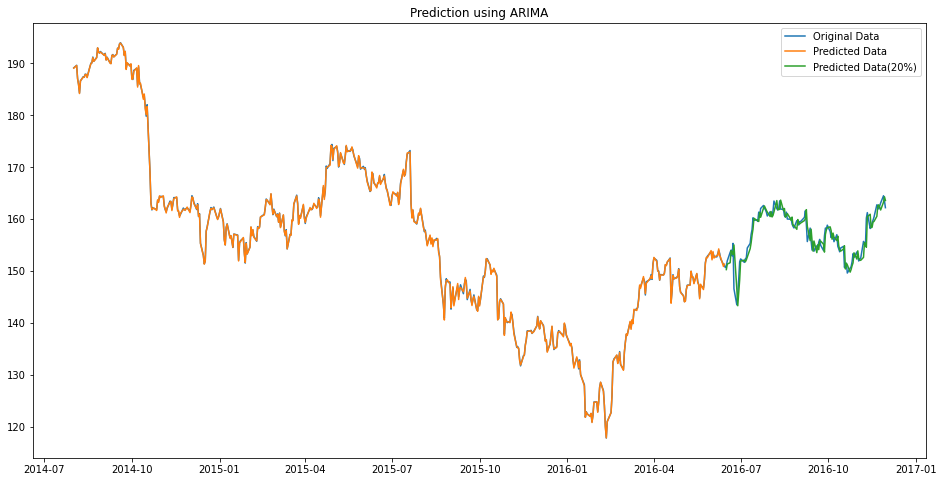

In [21]:
plt.figure(figsize=(16,8))
plt.plot(date,data, label='Original Data')
plt.plot(date[:int(0.8*len(data))],forecast[:int(0.8*len(data))], label='Predicted Data')
plt.plot(date[int(0.8*len(data))+1:],forecast[int(0.8*len(data)):], label='Predicted Data(20%)')
plt.legend()
plt.title('Prediction using ARIMA')

### Fitting only train data to the ARIMA model

In [22]:
model0 = ARIMA(train,order=(1,1,1))
model_fit0 = model0.fit()

In [23]:
forecast0 = model_fit0.predict(len(train),len(train)+len(test)-1,typ='levels')

In [24]:
rmse0 = np.sqrt(np.mean(np.power((np.array(test)-np.array(forecast0)),2)))
print('RMSE value using ARIMA model (train data only): ',rmse0)

RMSE value using ARIMA model (train data only):  11.834316879142401


Text(0.5, 1.0, 'Prediction using ARIMA')

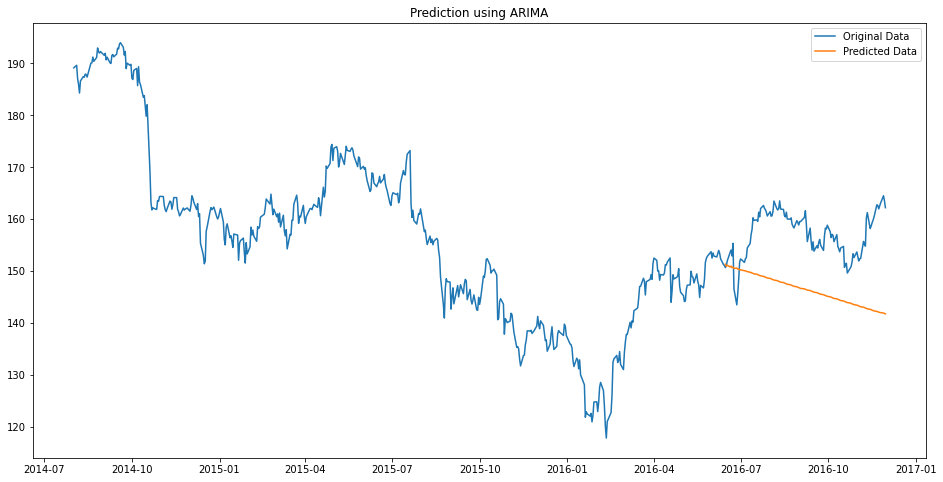

In [25]:
plt.figure(figsize=(16,8))
plt.plot(date,data, label='Original Data')
plt.plot(date[int(0.8*len(data)):],forecast0, label='Predicted Data')
plt.legend()
plt.title('Prediction using ARIMA')

## **Exponential Smoothing**

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
n = int(len(ibm["Close"])*0.8)
data = ibm['Close'].to_numpy()
train2 = data[:n]
test2 = data[n:]
date = (ibm.index)

In [28]:
Exp_model = ExponentialSmoothing(ibm.Close,trend='mul',seasonal='mul',seasonal_periods=4)
ibm['Pred_Exp'] = Exp_model.fit(smoothing_level = 0.9,smoothing_slope= 0.1,smoothing_seasonal = 0.2).fittedvalues.shift(0)

In [29]:
rmse2 = np.sqrt(np.mean(np.power((np.array(test2)-np.array(ibm.Pred_Exp[n:])),2)))
print('RMSE value using Exponential Smoothing model: ',rmse2)

RMSE value using Exponential Smoothing model:  1.8485760646136666


Text(0.5, 1.0, 'Prediction using Exponential Smoothing')

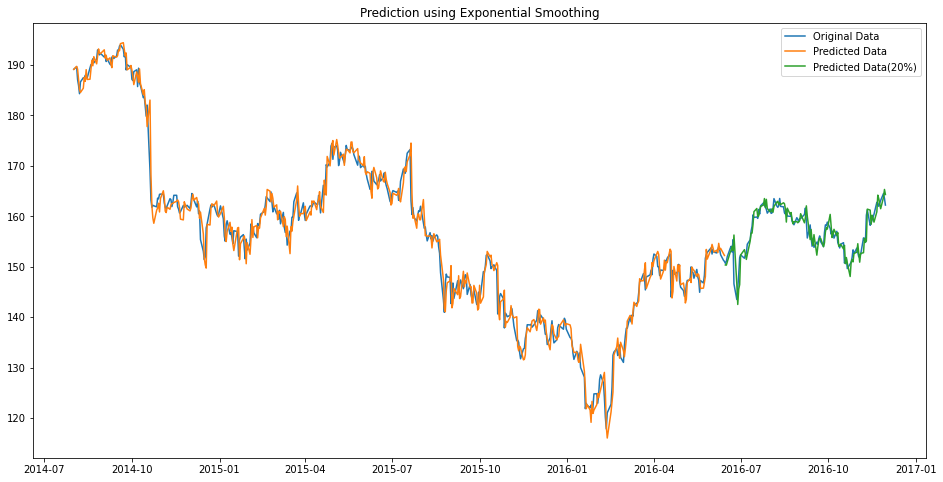

In [30]:
plt.figure(figsize=(16,8))
plt.plot(date,data, label='Original Data')
plt.plot(date[:n],ibm.Pred_Exp[:n], label='Predicted Data')
plt.plot(date[n:],ibm.Pred_Exp[n:], label='Predicted Data(20%)')
plt.legend()
plt.title('Prediction using Exponential Smoothing')

## **LSTM Model**

In [31]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [32]:
df1=ibm['Close']
date = (ibm.index)

In [33]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
##splitting dataset into train and test split
training_size = int(0.8*len(df1))
test_size = len(df1)-training_size
train_data = df1[0:training_size]
test_data = df1[training_size:len(df1)] 

In [35]:
# convert an array of values into a dataset matrix 
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0]) 
	return np.array(dataX), np.array(dataY) 

In [36]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 5
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [37]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [38]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
8/8 [==============================] - 7s 241ms/step - loss: 0.2651 - val_loss: 0.1022
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0777 - val_loss: 0.0121
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0323 - val_loss: 0.0028
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0156 - val_loss: 0.0071
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0173 - val_loss: 0.0017
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0104 - val_loss: 0.0021
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 9/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 10/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 11/100
8/8 [

In [41]:
# prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [42]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [43]:
Y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(ytest.reshape(-1, 1))

In [44]:
# Train data RMSE
rmse3 = np.sqrt(np.mean(np.power((np.array(Y_train)-np.array(train_predict)),2)))
print('RMSE value of train data using LSTM model',rmse3)

RMSE value of train data using LSTM model 3.422533952788419


In [45]:
# Test Data RMSE
rmse4 = np.sqrt(np.mean(np.power((np.array(Y_test)-np.array(test_predict)),2)))
print('RMSE value of test data using LSTM model',rmse4)

RMSE value of test data using LSTM model 2.656032451594327


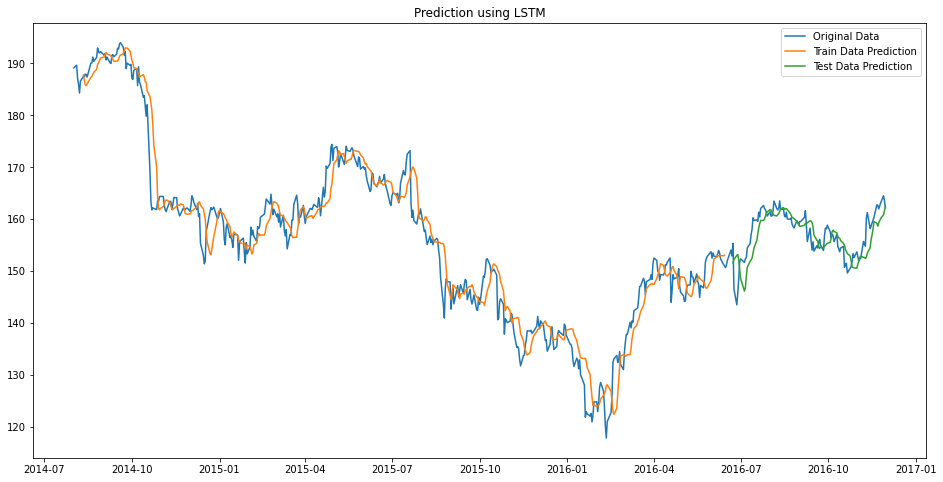

In [46]:
# plot baseline and predictions
look_back=5
plt.figure(figsize=(16,8))
plt.plot(date,scaler.inverse_transform(df1), label='Original Data')
plt.plot(date[look_back+1:training_size],train_predict, label='Train Data Prediction')
plt.plot(date[training_size+look_back+1:],test_predict, label='Test Data Prediction')
plt.legend()
plt.title('Prediction using LSTM')
plt.show()

## **Inference**

For a taken parameter, RMSE value on test data using 

(1) ARIMA Model: 1.6630943070076387

(2) Exponential Smoothing: 1.8485760646136666

(3) LSTM: 2.7803292896838854

 So from this and plot we can say that ARIMA predicts better for a given parametr. In actual, above sentence can not be said. Statistical models like ARIMA , Exponential smoothing are not training the model like DL,ML model. 

 Also, if we give high time-step in LSTM, It can predict much more accurate. So from  this conclusion is that deep learning models can be improved and can predict efficiently compare to stats model.